In [108]:
# dtmm configuration 
import dtmm2.conf
from dtmm2.conf import CDTYPE, FDTYPE

# core TMM functions for 1D calculation using plane waves
from dtmm2.tmm import alphaffi, alphaf, fvec2hevec, phase_mat,hzez_mat, beam_eig, \
             transfer_beam, hevec, beam_transfer_mat, layer_mat,transfer_mat, avec, \
            avec2fvec, field_mat, system_mat, reflection_mat, reflect,  avec2fvec, poynting, fvec2avec, project

from dtmm2 import tmm

# sorce (beam) creation functions
from dtmm2.source import scalar_field, vector_field

# extended TMM matrices for beam propagation
from dtmm2.matrix import mode_diffraction_mat, mode_cover_mat, mode_refraction_mat,  apply_mode_matrix, mode_hzez_mat
from dtmm2.matrix import field_diffraction_mat,  field_cover_mat, field_refraction_mat,  apply_field_matrix, field_transmittance_mat

# operators for beams
from dtmm2.operator import lens_transform, focal_pixelsize

# some conversion functions
from dtmm2.data import matrix2tensor, eps2epsva, chi2array

# scalar waves and helper functions
from dtmm2.wave import betaphi, eigenmask, k0, planewave, wave2eigenwave

# general 4x4 and 2x2 linear algebra (matrix and vector dot functions)
from dtmm2.linalg import multi_dot, dotmv, dotmf, eig, dotmm, dotchi2v, inv, dotmf

# functions for vector/tensor rotation matrix creation and rotations
from dtmm2.rotation import rotation_matrix, rotate_vector, rotate_diagonal_tensor, rotate_tensor

# 2D field creation and conversion functions
from dtmm2.field import field2modes, modes2field, field2intensity, field2poynting, field2fvec, fvec2field

# fft functions
from dtmm2.fft import fft2, ifft2

from dtmm2.jones import jonesvec, polarizer

# progress bar printing
from dtmm2.print_tools import print_progress

# non-dtmm2 stuff
#%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

def polstr(pol):
    """Returns string representation of the polarization state"""
    x,y = pol
    return '({:.2f},{:.2f})'.format(x,y)
    
# To convert from intensity to internal unitless E field representation, we must normalize with impedance of free space and multiply by 2.
# The factor 2 is needed because of the current implementation of the poynting() function in dtmm, which omits 0.5 term in ExH product.
# This assures proper creation of the input field amplitude from the requestet intensity in SI units.
Z0 = 376.73 * 2

In [157]:
# User constants and configuraion
# ///////////////////////////////
dtmm2.conf.set_verbose(2) # for progress bar
# data sampling shape, choose wisely

SHAPE = (20,20,20) # data shape (n layers, n pixels height, n pixels width)
# which polarization states of input light we compute for.

POLARIZERS = [(1,0),(1,0),(1,1j),(1,1j),(0,1),(0,1),(1,-1j),(1,-1j)]
ANALIZERS  = [(1,0),(0,1),(1,1j),(1,-1j),(0,1),(1,0),(1,-1j),(1,1j)]

POLARIZERS = jonesvec(POLARIZERS)
ANALIZERS = jonesvec(ANALIZERS)

# intensity used for single-wavelength calculation
INTENSITY = 1e6
# wave propagation parameter for single-wavelength calculation
BETA = 0 # see dtmm documentation on this, the beta parameter n*sin(theta)
# The phi angle of the wave, only matters if BETA != 0
PHI = 0 
# wavelength range for the multi-wavelength calculation
WAVELENGTHS = np.linspace(380,680,11) # nm
# wave intensity for each of the waves of the multi-wavelength calculation.
INTENSITIES = [INTENSITY]*len(WAVELENGTHS)
# wave beta parameter for each of the waves of the multi-wavelength calculation.
BETAS = [BETA]*len(WAVELENGTHS) 
# wave phi parameter for each of the waves of the multi-wavelength calculation.
PHIS = [PHI]*len(WAVELENGTHS) 

# sample thickness
THICKNESS = 3.1 # microns
# imaged region 
WIDTH = 40. # microns
HEIGHT = 40. # microns

# cover/substrate glass refractive index
NCOVER = 1.5

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# STOP! Computed constants, Do not set manually!
# //////////////////////////////////////////////

STEPSIZE = THICKNESS/SHAPE[0]*1000 #nm
# unitless wave number of fundamental and shg waves. Do not set manually!
#K0 = 2*np.pi/WAVELENGTH * STEPSIZE
K0S = 2*np.pi/WAVELENGTHS * STEPSIZE


# epsilon and euler angles for the cover glass
EPSILON0 = np.ones((3,)) * NCOVER **2
ANGLES0 = np.zeros((3,)) 

# matrices size in MB for single-wavelength run
MB_WAVELENGTH = 2* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# matrices size in MB for single-pixel run
MB_PIXEL = 2* len(WAVELENGTHS) * SHAPE[0]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# required memroy size for full computation
GB_FULL = 2*len(WAVELENGTHS)* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024/1024 * np.dtype(CDTYPE).itemsize 

# matrices size in MB for single-wavelength run
MB_WAVELENGTH_F = len(POLARIZERS)*MB_WAVELENGTH//SHAPE[0]
# matrices size in MB for single-pixel run
MB_PIXEL_F = len(POLARIZERS)*MB_PIXEL//SHAPE[0]
# required memroy size for full computation
GB_FULL_F = len(POLARIZERS)*GB_FULL//SHAPE[0]

def print_model_info():
    print("Domain size:")
    print(f'  {len(WAVELENGTHS)} x {SHAPE}')
    print()
    print('Approximate matrices memory:')
    print(' Single-wavelength : {:.1f} MB'.format(MB_WAVELENGTH))
    print(' Single-pixel      : {:.1f} MB'.format(MB_PIXEL))
    print(' Full computation  : {:.2f} GB'.format(GB_FULL))
    print()
    print('Approximate fields memory:')
    print(' Single-wavelength : {:.1f} MB'.format(MB_WAVELENGTH_F))
    print(' Single-pixel      : {:.1f} MB'.format(MB_PIXEL_F))
    print(' Full computation  : {:.2f} GB'.format(GB_FULL_F))
    print()
    print('Sample parameters:')
    print(f' Cover glass: n = {NCOVER}')
    print(f' Sample thickness: {THICKNESS} um')
    print(f' Sample width: {WIDTH} um')
    print(f' Sample height: {HEIGHT} um')
    print()
    print('Multi-wavelength parameters')
    print(' Wavelength range : {:.1f} - {:.1f} nm'.format(min(WAVELENGTHS), max(WAVELENGTHS)))
    print(' Intensity range  : {:.1f} - {:.1f} W/m2'.format(min(INTENSITIES), max(INTENSITIES)))
    print(' Number of waves  : {}'.format(len(WAVELENGTHS)))
    print()
    print('Single-wavelength parameters')
    print(f' Intensity  : {INTENSITY} W/m2' )
    print()
    print('Polarizations')
    print(POLARIZERS)
    print()
    print('Calculation parameters')
    print(f' Step size: {STEPSIZE} nm')

print_model_info()


Domain size:
  11 x (20, 20, 20)

Approximate matrices memory:
 Single-wavelength : 3.9 MB
 Single-pixel      : 0.1 MB
 Full computation  : 0.04 GB

Approximate fields memory:
 Single-wavelength : 1.0 MB
 Single-pixel      : 0.0 MB
 Full computation  : 0.00 GB

Sample parameters:
 Cover glass: n = 1.5
 Sample thickness: 3.1 um
 Sample width: 40.0 um
 Sample height: 40.0 um

Multi-wavelength parameters
 Wavelength range : 380.0 - 680.0 nm
 Intensity range  : 1000000.0 - 1000000.0 W/m2
 Number of waves  : 11

Single-wavelength parameters
 Intensity  : 1000000.0 W/m2

Polarizations
[[ 1.        +0.j          0.        +0.j        ]
 [ 1.        +0.j          0.        +0.j        ]
 [ 0.70710678+0.j          0.        +0.70710678j]
 [ 0.70710678+0.j          0.        +0.70710678j]
 [ 0.        +0.j          1.        +0.j        ]
 [ 0.        +0.j          1.        +0.j        ]
 [ 0.70710678+0.j         -0.        -0.70710678j]
 [ 0.70710678+0.j         -0.        -0.70710678j]]

Calc

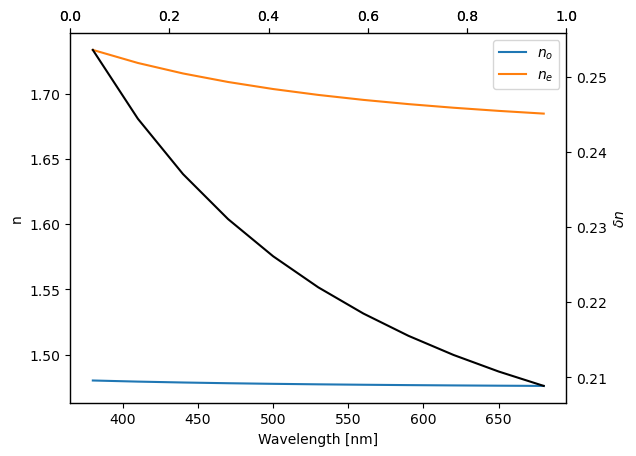

In [158]:

def ne(wavelength):
    return 1.66273 + 10256.6/(wavelength**2)

def no(wavelength):
    return 1.47415 + 874.107/(wavelength**2)

# we actualy use n1, n2, n3 functions, so we need to map no and ne
n1 = no 
n2 = no 
n3 = ne 

# plot for visual inspection

fix, ax1 = plt.subplots(1)
axd1 = ax1.twinx()

plt.ylabel(r'$\delta n$')
ax2 = ax1.twiny()
axd2 = axd1.twiny()

l1 = ax1.plot(WAVELENGTHS, no(WAVELENGTHS), label = '$n_o$')
l2 = ax1.plot(WAVELENGTHS, ne(WAVELENGTHS), label = '$n_e$')

ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('n')

axd1.plot(WAVELENGTHS, ne(WAVELENGTHS) - no(WAVELENGTHS), 'k', label =r'$\delta n$')

ls = l1 + l2 
lbls = [l.get_label() for l in ls]
plt.legend(ls, lbls)
plt.show()


Single-wave parameters
 Psi range:   0.000 - 0.000 rad
 Theta range: 1.571 - 1.571 rad
 Phi range:   -0.693 - 0.693 rad

Multi-wavelength parameters
 Psi range:   0.000 - 0.000 rad
 Theta range: 1.571 - 1.571 rad
 Phi range:   0.538 - 0.693 rad
 I index : 5
 J index : 5


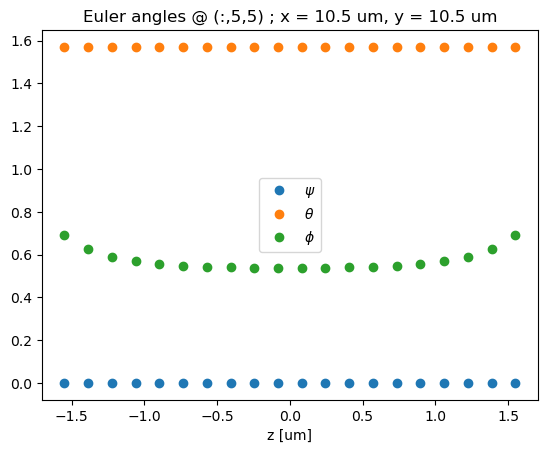

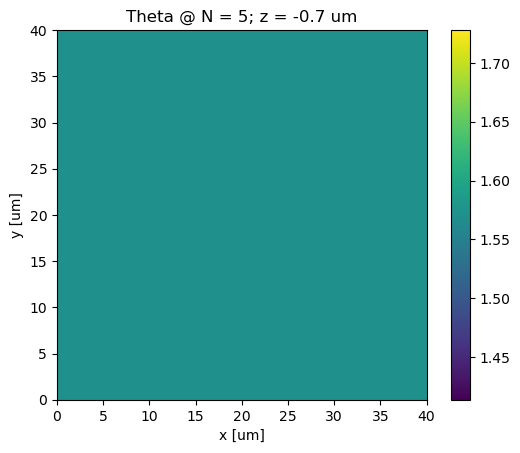

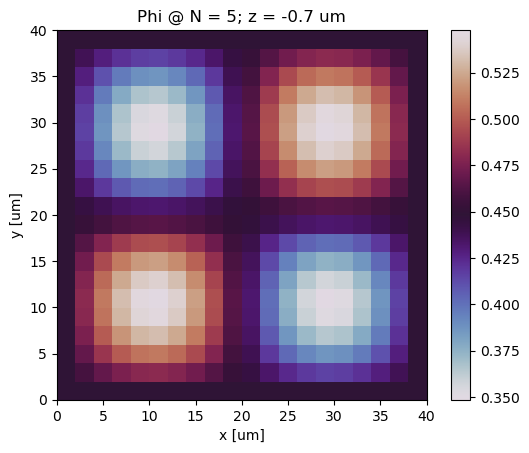

In [159]:
I = 5 # height index for single-pixel run
J = 5 # width index for single-pixel run
N = 5 # layer index for plotting

MOD= 40. #modulation constant
TWIST = 30 * np.pi/180 # max mid-plane twist
KSI= 0.2 # the ksi constant - see :funf:`ampl`
AMP = 40 * np.pi/180 # surface alignment angle 

def ampl(z, ksi = 0.2):
    return np.exp(-(-2.*(z/THICKNESS)**2 + 1./2.)/ksi)
    
def psi(x,y,z):
    return 0.0 # For uniaxial set to zero or any value
    
def theta(x,y,z, ksi = KSI, twist = TWIST):
    return np.pi/2  #+twist*(1 - (ampl(z, ksi)))

def phi(x,y,z, amp = AMP, mod = MOD, twist = TWIST, ksi = KSI):
    #return amp* np.sin(2*np.pi/mod *(x))* np.sin(2*np.pi/mod *(y)) + twist*(1 - (ampl(z, ksi)))
    return amp*(ampl(z,ksi))* np.sin(2*np.pi/mod *(x))* np.sin(2*np.pi/mod *(y)) + twist*(1 - (ampl(z, ksi))) #+ z/3

# computed parameters. Do not change these!
#//////////////////////////////////////////

# range of coordinates in z,y, and x directions
z = np.linspace(-THICKNESS/2,THICKNESS/2, SHAPE[0])
y = np.linspace(0,HEIGHT, SHAPE[1])
x = np.linspace(0,WIDTH, SHAPE[2])

# we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
zzz,yyy,xxx = np.meshgrid(z,y,x, indexing = 'ij')

# create an empty placehold of floats
ANGLES = np.empty(SHAPE+(3,), dtype = FDTYPE)
# fill the array
ANGLES[...,0] = psi(xxx,yyy,zzz)
ANGLES[...,1] = theta(xxx,yyy,zzz)
ANGLES[...,2] = phi(xxx,yyy,zzz)

def print_director_info():
    print('Single-wave parameters')
    print(' Psi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,0].min(), ANGLES[...,0].max()))
    print(' Theta range: {:.3f} - {:.3f} rad'.format(ANGLES[...,1].min(), ANGLES[...,1].max()))
    print(' Phi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,2].min(), ANGLES[...,2].max()))
    print()
    print('Multi-wavelength parameters')
    print(' Psi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,0].min(), ANGLES[...,I,J,0].max()))
    print(' Theta range: {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,1].min(), ANGLES[...,I,J,1].max()))
    print(' Phi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,2].min(), ANGLES[...,I,J,2].max()))
    print(f' I index : {I}' )
    print(f' J index : {J}' )
    
print_director_info()

# We plot angles with modulo 2*pi 
mod = 2*np.pi

fig = plt.figure()
plt.plot(z, ANGLES[:,I,J,0]%mod ,'o',label = r'$\psi$')
plt.plot(z, ANGLES[:,I,J,1]%mod ,'o',label = r'$\theta$')
plt.plot(z, ANGLES[:,I,J,2]%mod ,'o',label = r'$\phi$')
plt.xlabel('z [um]')
plt.title(r'Euler angles @ (:,{},{}) ; x = {:.1f} um, y = {:.1f} um'.format(I,J,xxx[N,I,J], yyy[N,I,J]))
plt.legend()

fig = plt.figure()
im1 = plt.imshow(ANGLES[N,:,:,1]%mod , origin = 'lower', extent = (0,HEIGHT, 0, WIDTH))
plt.title(r'Theta @ N = {}; z = {:.1f} um'.format(N, z[N]))
fig.colorbar(im1)
plt.xlabel('x [um]')
plt.ylabel('y [um]')

fig = plt.figure()
im2 = plt.imshow(ANGLES[N,:,:,2]%(mod/2) , origin = 'lower', extent = (0,HEIGHT, 0, WIDTH),cmap = 'twilight')
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title(r'Phi @ N = {}; z = {:.1f} um'.format(N, z[N]))
fig.colorbar(im2)

In [160]:
jones = np.asarray(POLARIZERS) #must be a normalized jones vector! 
jones = jones[:,None,None,None,:] #add dummy axes for broadcasting

f0 = field_mat(EPSILON0[None,None,None,None,:], ANGLES0[None,None,None,None,:], BETA, PHI)

intensities = np.asarray(INTENSITIES)[None,:,None,None]

# Jones vector representation of the fundamental input beam in unitless amplitude notation.
ampl = np.zeros((len(POLARIZERS),len(WAVELENGTHS), SHAPE[1],SHAPE[2], 4), dtype = CDTYPE)
ampl[...,0] = jones[...,0] * (intensities*Z0)**0.5
ampl[...,2] = jones[...,1] * (intensities*Z0)**0.5

# epsilon tensors of fundamental and shg waves
# we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
epsilon = np.zeros((SHAPE[0],len(WAVELENGTHS),1,1,6))
epsilon[...,0] = (n1(WAVELENGTHS)**2) [None,:,None,None]
epsilon[...,1] = (n2(WAVELENGTHS)**2) [None,:,None,None]
epsilon[...,2] = (n3(WAVELENGTHS)**2) [None,:,None,None]

# normalized layer thickness of fundamental and shg waves
kds = np.array((K0S,)* SHAPE[0])[:,None,:,None,None]

angles = ANGLES

E = np.empty((len(POLARIZATIONS),len(WAVELENGTHS),SHAPE[1],SHAPE[2],3), dtype = CDTYPE)


In [161]:
print('Building layer matrices of the fundamental wave')
# we propagate forward and only half step so that we can access mid-plane 
matrices = [transfer_mat(kds[i], epsilon[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
#print("Building HzEz matrices")
#hzez1 = hzez_mat(epsilon, angles, BETA, PHI)
print('Calculating stack matrices')
# we apply each matrix twice because these are half-layer matrices
stack_matrix = multi_dot((m for m in matrices),transfer = "forward")
print('Calculating system matrices')
smat = system_mat(stack_matrix, f0,f0, transfer = "forward")
print('Calculating reflection matrices')
rmat = reflection_mat(smat,transfer = 'forward')
print('Transferring fundamental field')
# convert from amplitude coefficients to EH field vector
field_in = avec2fvec(ampl,f0)
# compute output field, also modifies the input field to add reflected part
field_out = reflect(field_in, rmat,fmatin = f0, fmatout = f0)
# convert to amplitude coefficients
ampl_in = fvec2avec(field_in,f0)
ampl_out = fvec2avec(field_out,f0)
# reflected field intensity
intensityr = np.abs(ampl_in[...,1])**2 + np.abs(ampl_in[...,3])**2
intensityr/=Z0
# transmitted field intensity
intensityt = np.abs(ampl_out[...,0])**2 + np.abs(ampl_out[...,2])**2
intensityt/=Z0

# this should be zero except for a small numerical error.
loss = (intensityt+intensityr - intensities)/intensities


print('Done!')
print()
print('Intensity relative loss standard deviation', loss.std())

Building layer matrices of the fundamental wave
Calculating stack matrices
Calculating system matrices
Calculating reflection matrices
Transferring fundamental field
Done!

Intensity relative loss standard deviation 1.7438327635301195e-15


[ 0.70710678+0.j         -0.        -0.70710678j]


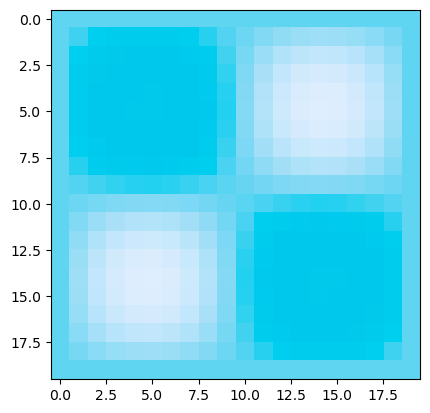

In [166]:
PINDEX = 3

P = POLARIZERS[PINDEX]
A = ANALIZERS[PINDEX]
print(A)

mat = polarizer(A)
out = dotmv(mat,ampl_out[PINDEX,...,0::2])

specter = np.abs(ampl_out[PINDEX,...,0])**2 #+ np.abs(ampl_out[PINDEX,...,2])**2
specter = np.abs(out[...,0])**2 + np.abs(out[...,1])**2

from dtmm import color

cmf = color.load_tcmf(WAVELENGTHS)

plt.imshow(color.specter2color(np.moveaxis(specter/10**6/Z0,0,-1),cmf))


In [153]:
POLARIZERS

array([[ 1.        +0.j        ,  0.        +0.j        ],
       [ 1.        +0.j        ,  0.        +0.j        ],
       [ 0.70710678+0.j        ,  0.        +0.70710678j],
       [ 0.70710678+0.j        ,  0.        +0.70710678j],
       [ 0.        +0.j        ,  1.        +0.j        ],
       [ 0.        +0.j        ,  1.        +0.j        ],
       [ 0.70710678+0.j        , -0.        -0.70710678j],
       [ 0.70710678+0.j        , -0.        -0.70710678j]])

In [58]:
kds[0,0,0].shape

(11, 1, 1)

In [28]:
from dtmm import color

In [29]:
color.specter2color?

Signature:
color.specter2color(
    spec,
    cmf,
    norm=False,
    gamma=True,
    gray=False,
    out=None,
)
Docstring:
Converts specter data to RGB data (color or gray).

Specter shape must be [...,k], where wavelengths are in the last axis. cmf 
must be a valid color matchin function array of size [k,3].

Parameters
----------
spec : array
    Specter data of shape [..., n] where each data element in the array has
    n wavelength values
cmf : array
    A color matching function (array of shape [n,3]) that converts the specter data 
    to a XYZ color.
norm : bool or float, optional
    If set to False, no data normalization is performed (default). If True,
    internally, xyz data is normalized in the range [0,1.], so that no clipping occurs.
    If it is a float, data is normalized to this value.
gamma : bool or float, optional
    If gamma is True srgb gamma function is applied (default). If float is
    provided, standard gamma factor is applied with a given gamma value. If